# Check Change in Performance with Increasing Number of Ensemble Members and ```n_splits``` for esol, RDKit, Deep Learning

<hr/>

#### Imports

In [1]:
import copy
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed
from ensemble_uncertainties.utils.ad_assessment import decreasing_coeff, rmses_frac

from sklearn.metrics import r2_score

from datetime import datetime

#### Constants

In [2]:
N_REPETITIONS = 100
N_SPLITS = 2
TASK = 'regression'
DATA_FOLDER = f'~/PowerFolders/ensemble_ad/data/featurized/{TASK}/'
RESULT_FOLDER = f'~/PowerFolders/ensemble_ad/data/results/initial_results/{TASK}/'
# Modified from the original implementation for this specific task
PLOT_FOLDER = './plots_esol_100_deep_rdkit_splits/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep']

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'IL4',
    'F7',
    'O14965'
]

#### Functions

In [4]:
# Modified from the original implementation for this specific task
def load_results_file(n_repetitions=N_REPETITIONS, n_splits=N_SPLITS):
    """Loads results from disk for a given combination of ML settings."""
    top = '/home/thomas/PowerFolders/ensemble_ad/data/results/initial_results/regression/esol_100_deep_rdkit_different_splits/'
    path = f'{top}splits_{n_splits}/single_predictions/test.csv'
    results = pd.read_csv(path, sep=';').set_index('id')
    single_tables = list()
    for i in range(n_repetitions):
        partial_results = results[[f'rep{i}_split{j}' for j in range(n_splits)]]
        single_tables.append(partial_results)
    return single_tables


def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def harmonize(values):
    """Subtracts smallest value and divides by largest, so all values will be in [0, 1]."""
    floored_values = values - values.min()
    scaled_floored_values = floored_values / floored_values.max()
    return scaled_floored_values


def cumulative_predictive_performance(single_tables, y):
    """Computes the change in R^2 when taking more and more ensemble members into account."""
    members = pd.DataFrame(index=y.index)
    scores = list()
    for i, member in enumerate(single_tables):
        members = pd.concat([members, member], axis=1)
        mean = members.mean(axis=1)
        scores.append(r2_score(y['y'], mean.values))
    scores = np.array(scores)
    return scores


def cumulative_performance(single_tables, y, do_harmonize=True):
    """Computes the change in R^2 and AUCO when taking more and more ensemble members into account."""
    members = pd.DataFrame(index=y.index)
    r2_scores = list()
    decreases = list()
    for i, member in enumerate(single_tables):
        # Collect members
        members = pd.concat([members, member], axis=1)
        # Compute necessary values
        mean = members.mean(axis=1)
        sdev = members.std(axis=1)
        resd = y['y'] - mean
        # Score predictive performance
        r2_scores.append(r2_score(y['y'], mean.values))
        # Score uncertainty performance
        oracle_rmses, measure_rmses = rmses_frac(resd, sdev)
        decrease = decreasing_coeff(measure_rmses)
        decreases.append(decrease)
    r2_scores = np.array(r2_scores)
    decreases = np.array(decreases)
    if do_harmonize:
        harmonized_r2_scores = harmonize(r2_scores)
        harmonized_decreases = harmonize(decreases)
        return harmonized_r2_scores, harmonized_decreases
    else:
        return r2_scores, decreases


def cumulative_performances_for_several_descriptors(name, algorithm, descriptors, n_repetitions=N_REPETITIONS, n_splits=N_SPLITS, do_harmonize=True):
    """Runs cumulative_performance for several descriptors."""
    single_tables_list = [load_results_file(name, algorithm, descriptor, n_repetitions=n_repetitions, n_splits=n_splits) for descriptor in descriptors]
    y = load_true(name)
    value_lists = [cumulative_performance(single_tables, y, do_harmonize) for single_tables in single_tables_list]
    return value_lists


def cumulative_performances_for_several_splits(name, n_splitss, do_harmonize):
    """Runs cumulative_performance for several n_splits."""
    single_tables_list = [load_results_file(n_splits=n_splits) for n_splits in n_splitss]
    y = load_true(name)
    value_lists = [cumulative_performance(single_tables, y, do_harmonize) for single_tables in single_tables_list]
    return value_lists


def plot_cumulative_scores(values_list, descriptors, ax, y_label):
    """Plot change over values for several descriptors."""
    ax.grid(zorder=100)
    for values, descriptor in zip(values_list, descriptors):
        ax.plot(values, zorder=100, label=descriptor)
    ax.set_xlabel('Number of ensemble members')
    ax.set_ylabel(y_label)
    ax.legend()


def plot_for_descriptors(name, algorithm, descriptors, n_splitss, n_repetitions=N_REPETITIONS, do_harmonize=True, plot_folder=PLOT_FOLDER):
    """Plot change of scores and AUCO for several descriptors in a comprehensive plot."""
    start = datetime.now()
    # Modified from the original implementation for this specific task
    value_lists = cumulative_performances_for_several_splits(name, n_splitss, do_harmonize=do_harmonize)
    fig, (ax_score, ax_dr) = plt.subplots(1, 2, figsize=(10, 5), frameon=False)
    if do_harmonize:
        title = f'{name}, {algorithm},\nn_repetitions={n_repetitions}, harmonized to [0, 1]'
        image_path = f'{plot_folder}{name}_{algorithm}_{n_repetitions}.png'
        state = 'Harmonized '
    else:
        title = f'{name}, {algorithm},\nn_repetitions={n_repetitions}, actual values'
        image_path = f'{plot_folder}{name}_{algorithm}_{n_repetitions}_unharmonized.png'
        state = 'Absolute '
    fig.suptitle(title)
    plot_cumulative_scores([v[0] for v in value_lists], n_splitss, ax_score, state + '$R^2$')
    plot_cumulative_scores([v[1] for v in value_lists], n_splitss, ax_dr, state + '$DR$')
    fig.tight_layout()
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()
    run_time = datetime.now() - start
    print(f'Took {format_time_elapsed(run_time)}')

<hr/>

### Evaluate

Plot unharmonized

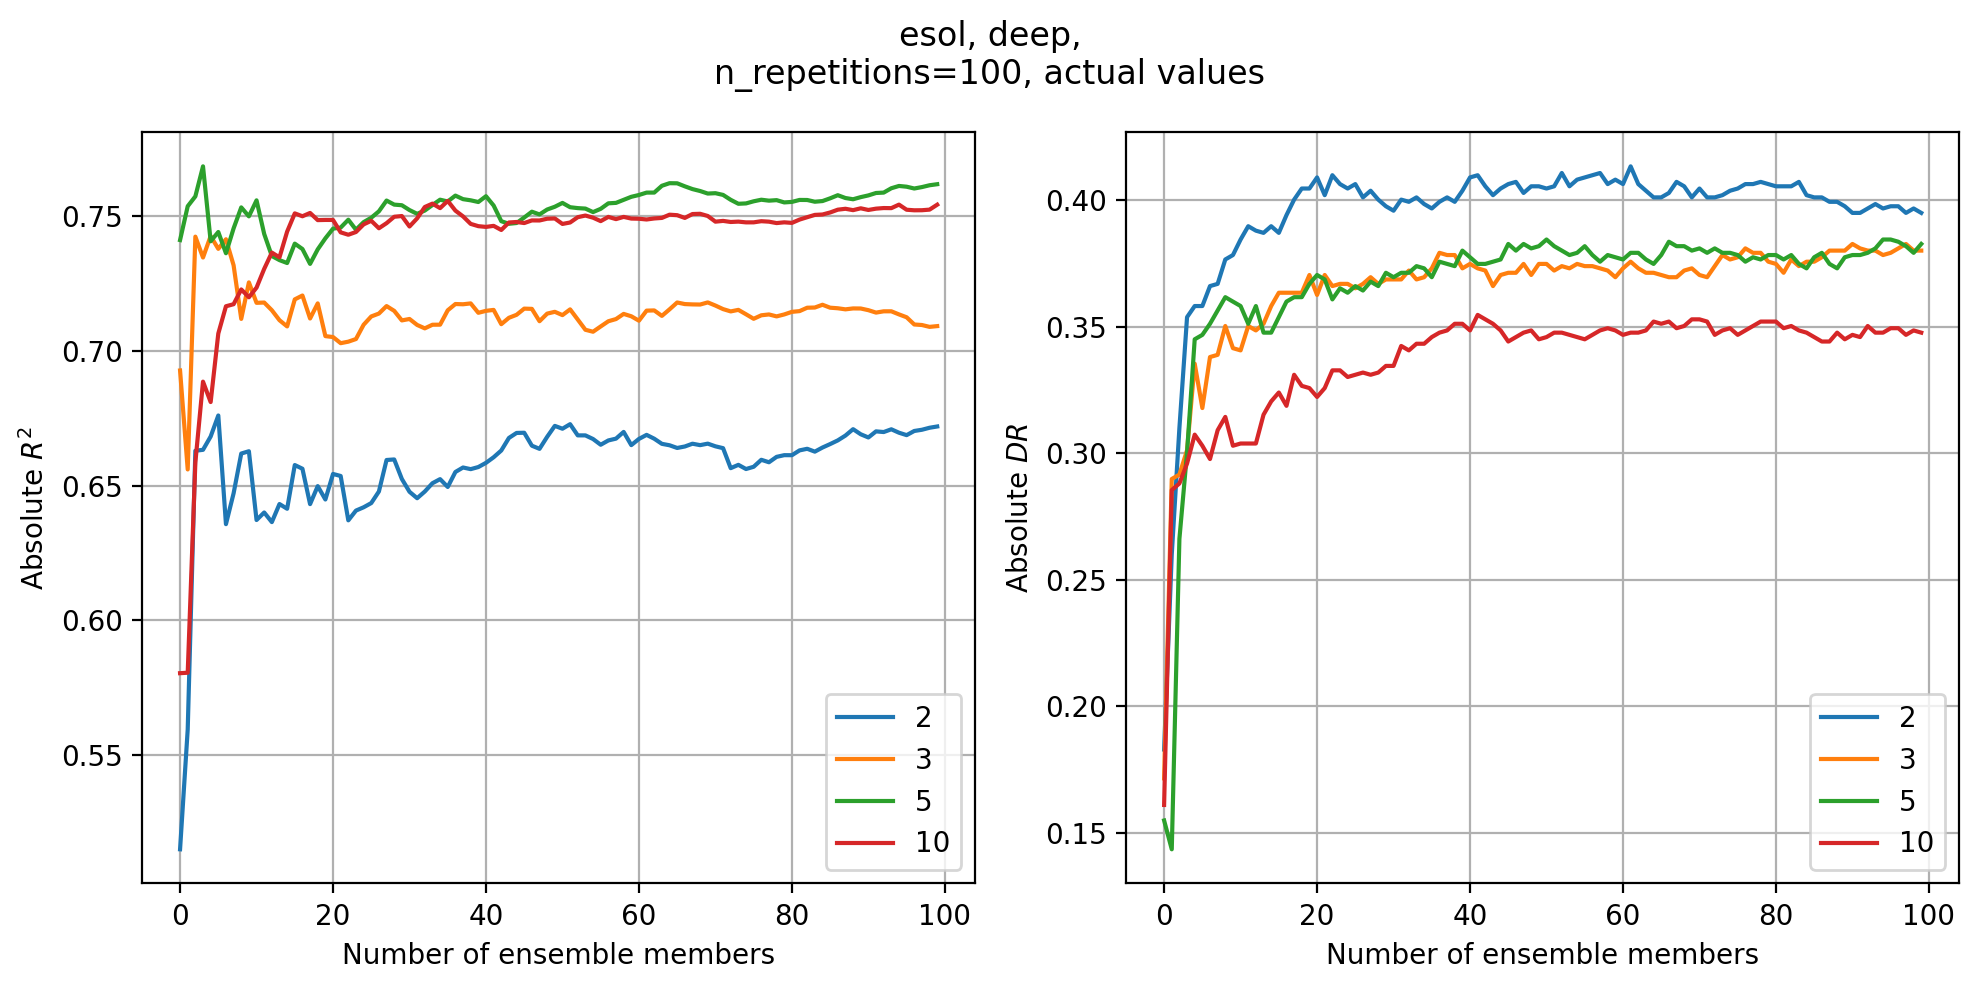

Took 1 Minute(s). 17 Second(s). 


In [5]:
n_splitss = [2, 3, 5, 10]

plot_for_descriptors('esol', 'deep', ['rdkit'], n_splitss, do_harmonize=False, plot_folder=f'{PLOT_FOLDER}unharmonized/')